
# Rozpoznawanie płci na podstawie głosu i mowy



## Wprowadzenie

Celem projektu jest identyfikacja płci na podstawie głosu, w oparciu o właściwości akustyczne głosu i mowy.
Zbiór danych który zostanie użyty w projekcie składa się z 3168 zarejestrowanych próbek głosu, zebranych od mówców płci męskiej i żeńskiej.
Próbki głosu są wstępnie przetwarzane przez analizę akustyczną w R przy użyciu pakietów seewave i tuneR, z analizowanym zakresem częstotliwości od 0 do 280 Hz (ludzki zakres wokalny).



## Przygotowanie środowiska


In [267]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
from scipy.cluster.hierarchy import linkage, dendrogram, ward, fcluster
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler

## Wczytanie danych


In [268]:
dane= pd.read_csv('voice.csv')
atrybuty=len(dane.columns)
obiekty=len(dane)
nf=pd.isnull(dane)
suma_kolumny=nf.sum(axis=0)
liczba_brakow=0
for k in suma_kolumny:
    liczba_brakow+=k
print("Ilość grup = " , dane.groupby(['label']).count().shape[0])
print("Ilość obiektów w pliku wejściowym = " ,obiekty)
print("Ilość atrybutów w pliku wejściowym = " ,atrybuty)


Ilość grup =  2
Ilość obiektów w pliku wejściowym =  3168
Ilość atrybutów w pliku wejściowym =  21


Następujące akustyczne parametry dźwięku każdego głosu, zostały zamieszczone w pliku z danymi:
*	meanfreq: średnia częstotliwość (in kHz)
*	sd: odchylenie standardowe częstotliwości
*	median: mediana (w kHz)
*	Q25: pierwszy kwartyl (w kHz)
*	Q75: trzeci kwartyl (w kHz)
*	IQR: rozstęp międzykwartylowy (w kHz)
*	skew: skośność 
*	kurt: kurtoza
*	sp.ent: spektralna entropia 
*	sfm: płaskość widmowa
*	mode: częstotliwość drgań swobodnych
*	centroid: centroid częstotliwości 
*	peakf: szczytowa częstotliowść (z największą energią)
*	meanfun: średnia wartość częstotliowści podstawowej
*	minfun: minimalna wartość częstotliowści podstawowej
*	maxfun: maksymalna wartość częstotliowści podstawowej
*	meandom: średnia wartość dominanty częstotliowści
*	mindom: minimalna wartość dominanty częstotliowści
*	maxdom: maksymalna wartość dominanty częstotliowści
*	dfrange: zakres dominanty
*	modindx: indeks modulacji
*	label: płeć

## Podgląd badanych danych

In [269]:
dane.head()

meanfreq        sd    median       Q25       Q75       IQR       skew  \
0  0.059781  0.064241  0.032027  0.015071  0.090193  0.075122  12.863462   
1  0.066009  0.067310  0.040229  0.019414  0.092666  0.073252  22.423285   
2  0.077316  0.083829  0.036718  0.008701  0.131908  0.123207  30.757155   
3  0.151228  0.072111  0.158011  0.096582  0.207955  0.111374   1.232831   
4  0.135120  0.079146  0.124656  0.078720  0.206045  0.127325   1.101174   

          kurt    sp.ent       sfm  ...    centroid   meanfun    minfun  \
0   274.402906  0.893369  0.491918  ...    0.059781  0.084279  0.015702   
1   634.613855  0.892193  0.513724  ...    0.066009  0.107937  0.015826   
2  1024.927705  0.846389  0.478905  ...    0.077316  0.098706  0.015656   
3     4.177296  0.963322  0.727232  ...    0.151228  0.088965  0.017798   
4     4.333713  0.971955  0.783568  ...    0.135120  0.106398  0.016931   

     maxfun   meandom    mindom    maxdom   dfrange   modindx  label  
0  0.275862  0.007812  0.007812  0.007812  0.000000  0.000000   male  
1  0.250000  0.009014  0.007812  0.054688  0.046875  0.052632   male  
2  0.271186  0.007990  0.007812  0.015625  0.007812  0.046512   male  
3  0.250000  0.201497  0.007812  0.562500  0.554688  0.247119   male  
4  0.266667  0.712812  0.007812  5.484375  5.476562  0.208274   male  

[5 rows x 21 columns]

In [270]:
def opisz_klasy(ramka_wej):
    df = ramka_wej.copy()
    d = df.describe()
    d.loc['label',:] = 'całość'
    for k in list(df.iloc[:,-1].unique()): 
        desc = df[df.iloc[:,-1] == k].describe()
        desc.loc['label',:] = k
        d = pd.concat([d, desc], axis=1, sort=False)
    return d


In [271]:
print(opisz_klasy(dane))


        meanfreq         sd     median          Q25        Q75        IQR  \
count       3168       3168       3168         3168       3168       3168   
mean    0.180907   0.057126   0.185621     0.140456   0.224765  0.0843094   
std    0.0299178  0.0166522  0.0363601    0.0486797  0.0236393  0.0427831   
min    0.0393633  0.0183632  0.0109746  0.000228758  0.0429463  0.0145577   
25%     0.163662  0.0419535   0.169593     0.111087   0.208747  0.0425597   
50%     0.184838  0.0591551   0.190032     0.140286   0.225684    0.09428   
75%     0.199146  0.0670204   0.210618     0.175939    0.24366   0.114175   
max     0.251124   0.115273   0.261224     0.247347   0.273469   0.252225   
label     całość     całość     całość       całość     całość     całość   

           skew     kurt     sp.ent        sfm    ...          mode  \
count      3168     3168       3168       3168    ...          1584   
mean    3.14017  36.5685   0.895127   0.408216    ...      0.178541   
std     4.24053 

Powyższe dane przedstawiają wartości statystyczne badanego zbioru danych takie jak:
* średnia
* odchylenie standardowe
* wartość minimalna
* pierwszy kwartyl
* mediana
* trzeci kwartyl
* wartość maksymalna



## Korelacja i grupowanie

Poniżej przedstawiono macierz korelacji poszczególnych par atrybutów. Oznaczenia płci zostały zamienione na wartości liczbowy aby umożliwić ich analizę. Oznaczenie kobiety zostało ustalone jako wartość "1" a mężczyzny jako "0".

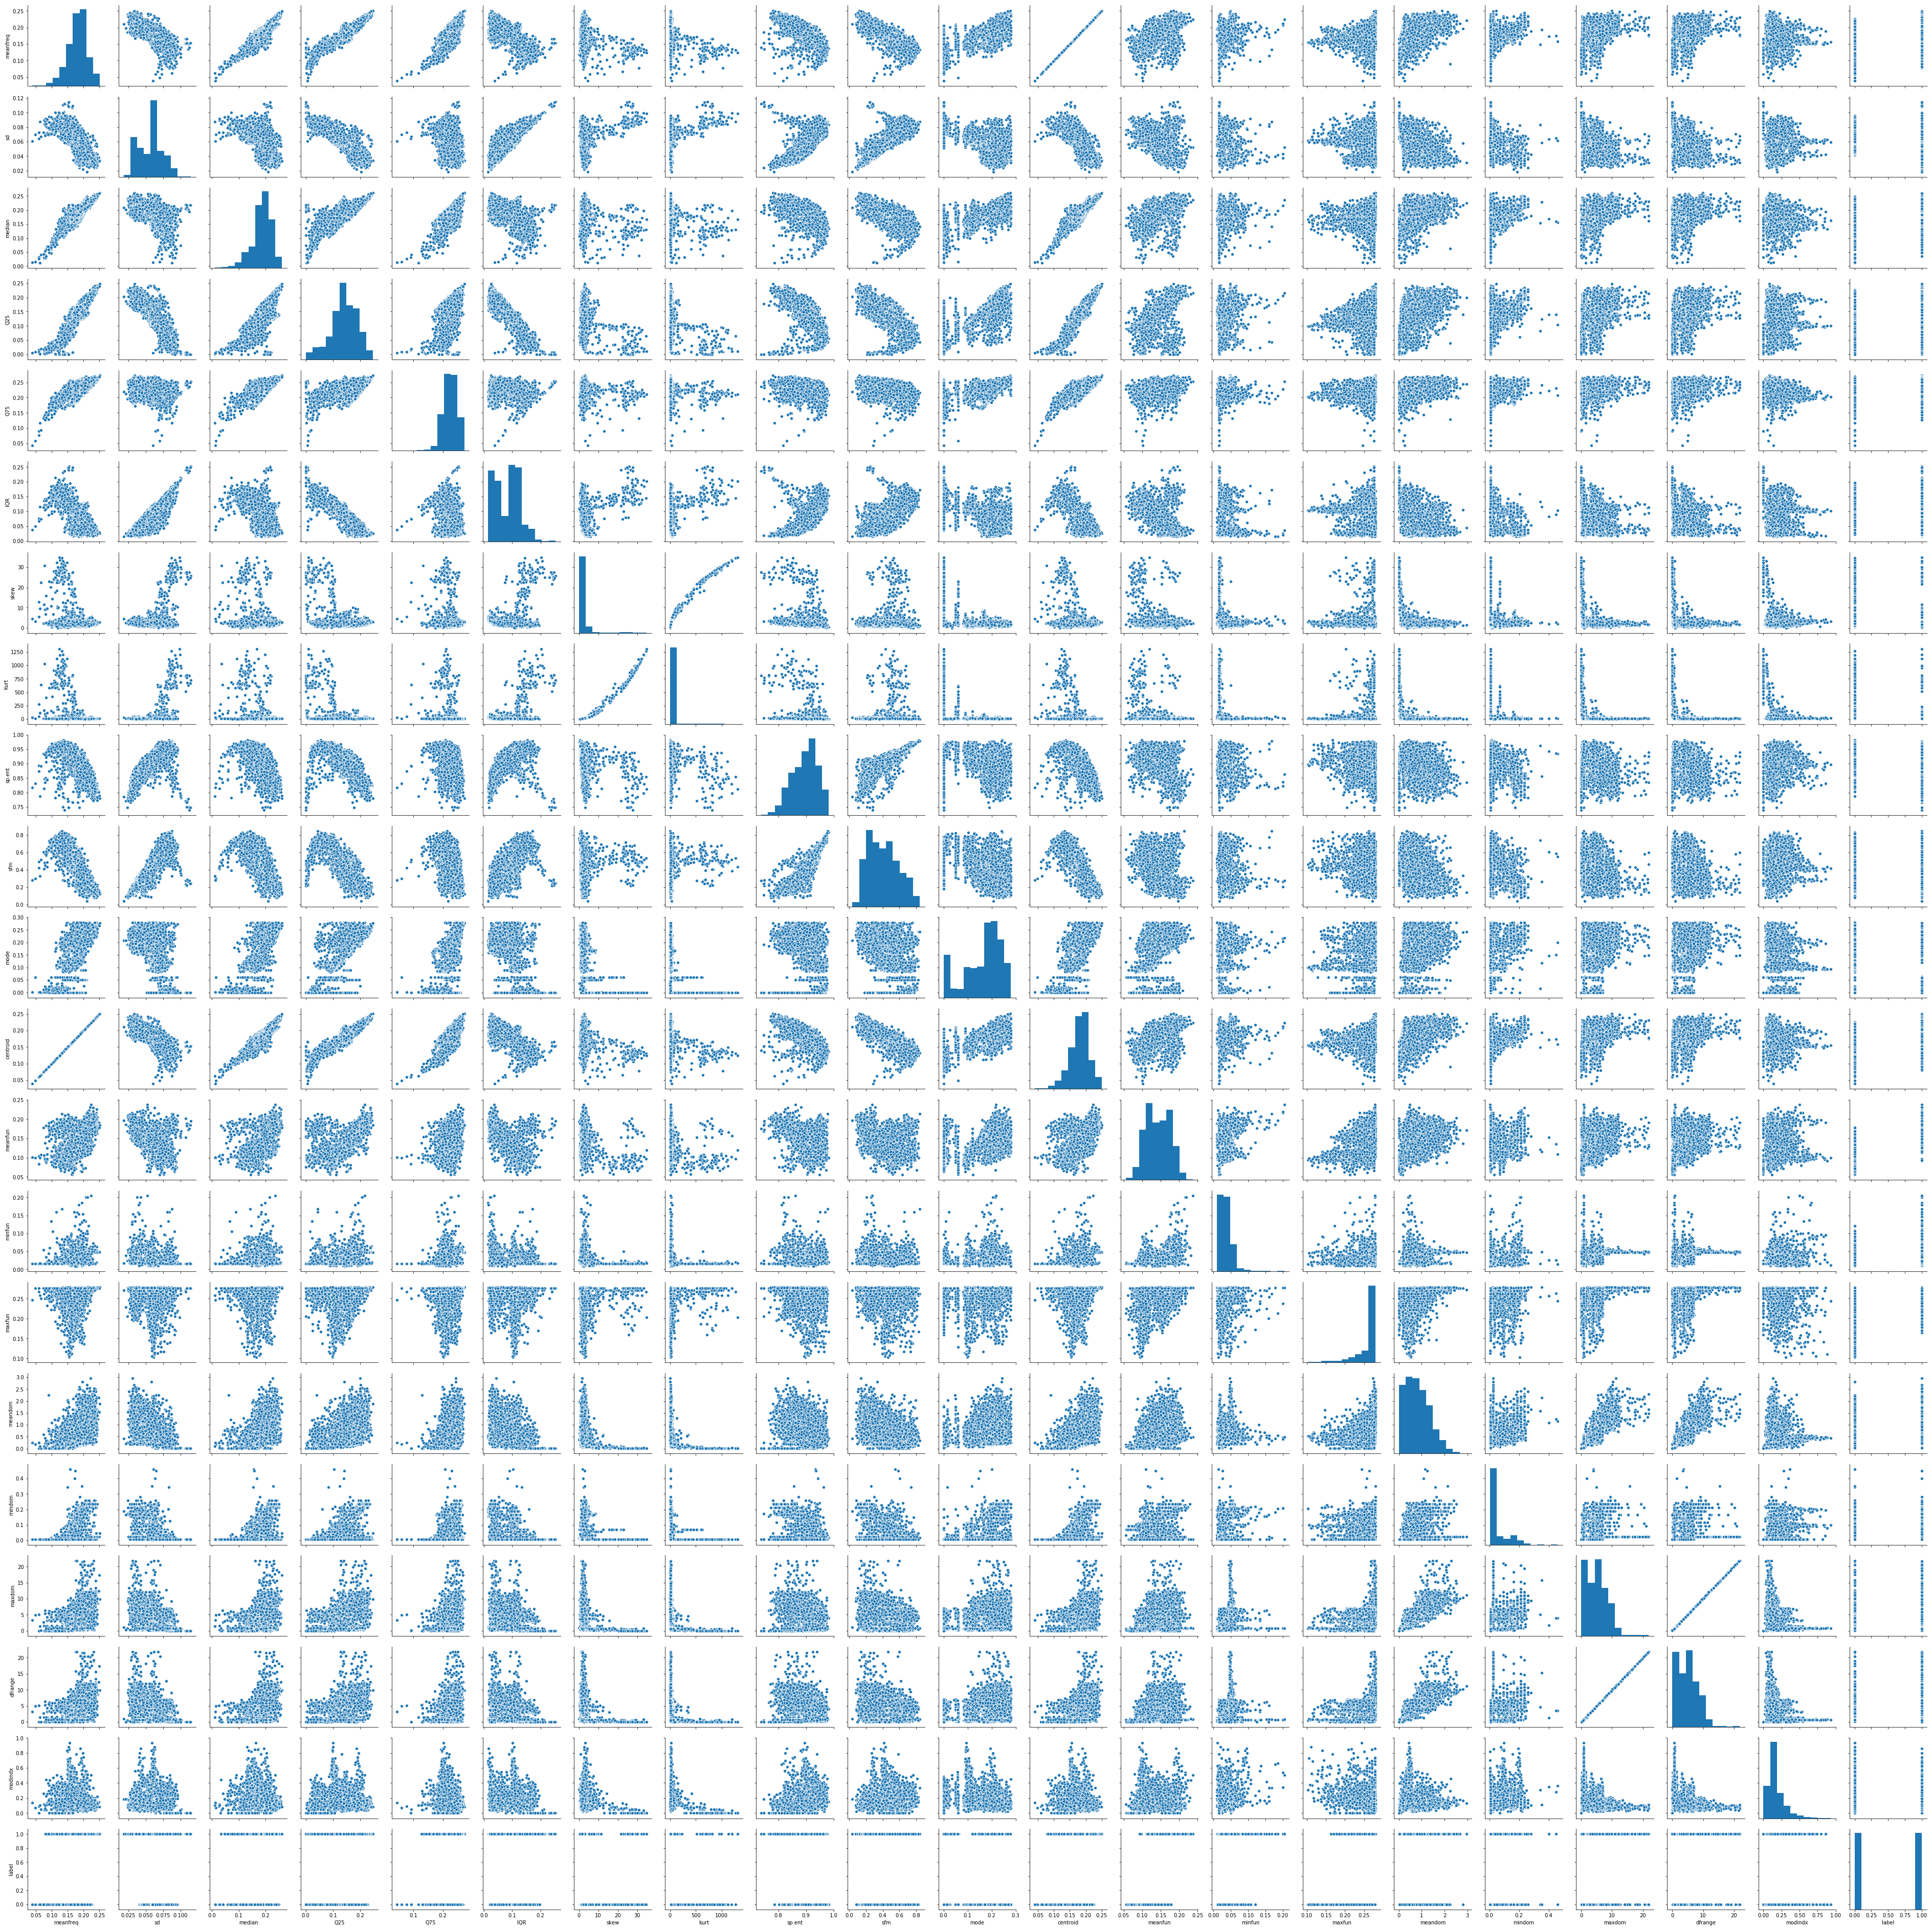

meanfreq        sd    median       Q25       Q75       IQR  \
meanfreq  1.000000 -0.739039  0.925445  0.911416  0.740997 -0.627605   
sd       -0.739039  1.000000 -0.562603 -0.846931 -0.161076  0.874660   
median    0.925445 -0.562603  1.000000  0.774922  0.731849 -0.477352   
Q25       0.911416 -0.846931  0.774922  1.000000  0.477140 -0.874189   
Q75       0.740997 -0.161076  0.731849  0.477140  1.000000  0.009636   
IQR      -0.627605  0.874660 -0.477352 -0.874189  0.009636  1.000000   
skew     -0.322327  0.314597 -0.257407 -0.319475 -0.206339  0.249497   
kurt     -0.316036  0.346241 -0.243382 -0.350182 -0.148881  0.316185   
sp.ent   -0.601203  0.716620 -0.502005 -0.648126 -0.174905  0.640813   
sfm      -0.784332  0.838086 -0.661690 -0.766875 -0.378198  0.663601   
mode      0.687715 -0.529150  0.677433  0.591277  0.486857 -0.403764   
centroid  1.000000 -0.739039  0.925445  0.911416  0.740997 -0.627605   
meanfun   0.460844 -0.466281  0.414909  0.545035  0.155091 -0.534462   
minfun    0.383937 -0.345609  0.337602  0.320994  0.258002 -0.222680   
maxfun    0.274004 -0.129662  0.251328  0.199841  0.285584 -0.069588   
meandom   0.536666 -0.482726  0.455943  0.467403  0.359181 -0.333362   
mindom    0.229261 -0.357667  0.191169  0.302255 -0.023750 -0.357037   
maxdom    0.519528 -0.482278  0.438919  0.459683  0.335114 -0.337877   
dfrange   0.515570 -0.475999  0.435621  0.454394  0.335648 -0.331563   
modindx  -0.216979  0.122660 -0.213298 -0.141377 -0.216475  0.041252   
label     0.337415 -0.479539  0.283919  0.511455 -0.066906 -0.618916   

              skew      kurt    sp.ent       sfm    ...     centroid  \
meanfreq -0.322327 -0.316036 -0.601203 -0.784332    ...     1.000000   
sd        0.314597  0.346241  0.716620  0.838086    ...    -0.739039   
median   -0.257407 -0.243382 -0.502005 -0.661690    ...     0.925445   
Q25      -0.319475 -0.350182 -0.648126 -0.766875    ...     0.911416   
Q75      -0.206339 -0.148881 -0.174905 -0.378198    ...     0.740997   
IQR       0.249497  0.316185  0.640813  0.663601    ...    -0.627605   
skew      1.000000  0.977020 -0.195459  0.079694    ...    -0.322327   
kurt      0.977020  1.000000 -0.127644  0.109884    ...    -0.316036   
sp.ent   -0.195459 -0.127644  1.000000  0.866411    ...    -0.601203   
sfm       0.079694  0.109884  0.866411  1.000000    ...    -0.784332   
mode     -0.434859 -0.406722 -0.325298 -0.485913    ...     0.687715   
centroid -0.322327 -0.316036 -0.601203 -0.784332    ...     1.000000   
meanfun  -0.167668 -0.194560 -0.513194 -0.421066    ...     0.460844   
minfun   -0.216954 -0.203201 -0.305826 -0.362100    ...     0.383937   
maxfun   -0.080861 -0.045667 -0.120738 -0.192369    ...     0.274004   
meandom  -0.336848 -0.303234 -0.293562 -0.428442    ...     0.536666   
mindom   -0.061608 -0.103313 -0.294869 -0.289593    ...     0.229261   
maxdom   -0.305651 -0.274500 -0.324253 -0.436649    ...     0.519528   
dfrange  -0.304640 -0.272729 -0.319054 -0.431580    ...     0.515570   
modindx  -0.169325 -0.205539  0.198074  0.211477    ...    -0.216979   
label    -0.036627 -0.087195 -0.490552 -0.357499    ...     0.337415   

           meanfun    minfun    maxfun   meandom    mindom    maxdom  \
meanfreq  0.460844  0.383937  0.274004  0.536666  0.229261  0.519528   
sd       -0.466281 -0.345609 -0.129662 -0.482726 -0.357667 -0.482278   
median    0.414909  0.337602  0.251328  0.455943  0.191169  0.438919   
Q25       0.545035  0.320994  0.199841  0.467403  0.302255  0.459683   
Q75       0.155091  0.258002  0.285584  0.359181 -0.023750  0.335114   
IQR      -0.534462 -0.222680 -0.069588 -0.333362 -0.357037 -0.337877   
skew     -0.167668 -0.216954 -0.080861 -0.336848 -0.061608 -0.305651   
kurt     -0.194560 -0.203201 -0.045667 -0.303234 -0.103313 -0.274500   
sp.ent   -0.513194 -0.305826 -0.120738 -0.293562 -0.294869 -0.324253   
sfm      -0.421066 -0.362100 -0.192369 -0.428442 -0.289593 -0.436649   
mode      0.324771  0.385467  0.172329  0.491479

In [272]:
dane= pd.read_csv('voice.csv')
inRelationsheapMap = {"female": 1, "male": 0}
dane.label = dane.label.map(inRelationsheapMap)
sns.pairplot(dane, kind="scatter")
plt.show()
dane.corr()

Macierz korelacji przedstawiona w postaci mapy ciepła, w celu uwidocznienia poszczególnych wartości korelacji.

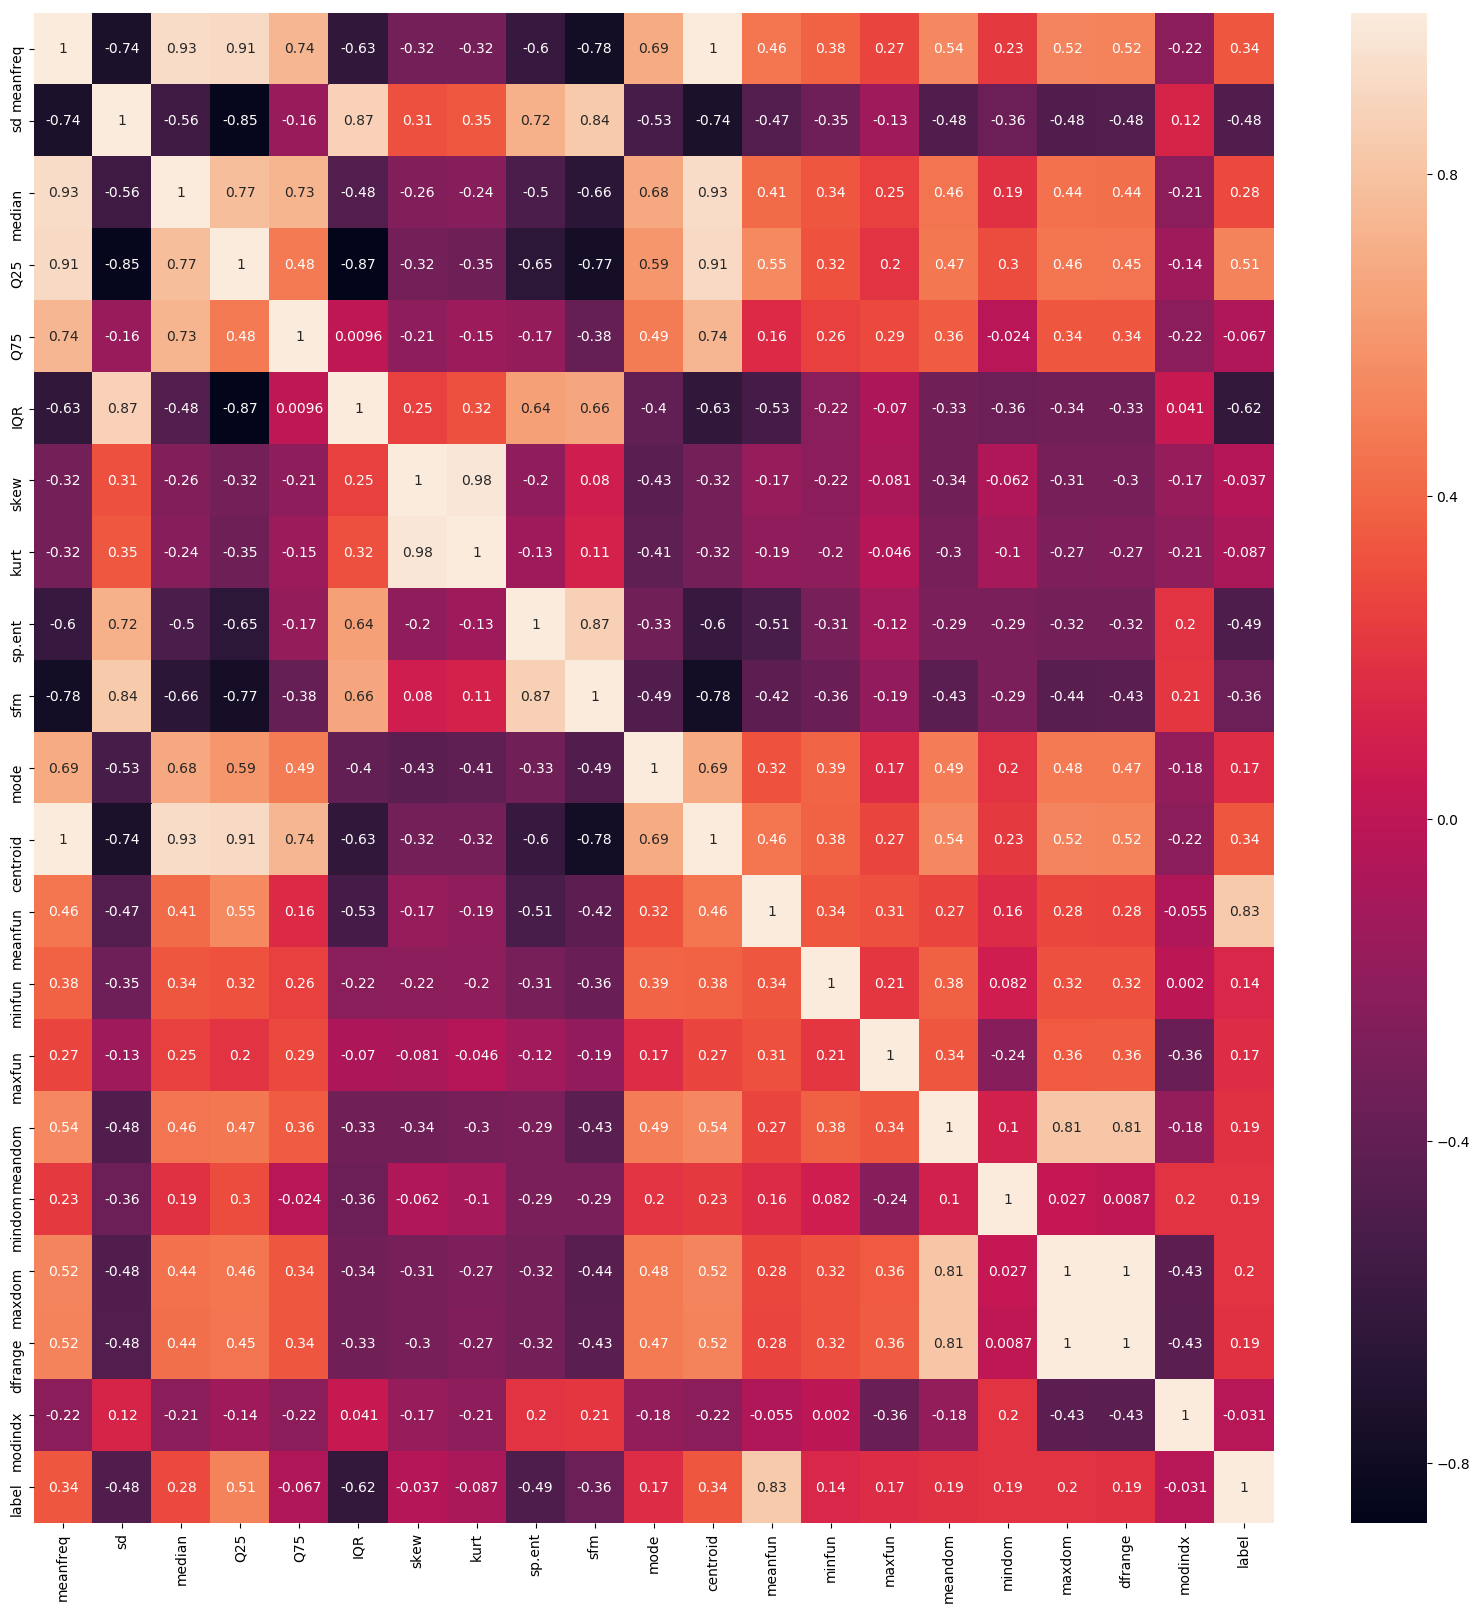

In [273]:
plt.figure(figsize=(20,20),dpi = 100)
sns.heatmap(dane.corr(),annot = dane.corr())

W celu dokonania klasyfikacji głosów zostały wybrane atrybuty najbardziej skorelowane z atrybutem określającym płeć. 
Poniżej przedstawiono mapę ciepła przedstawiającą korelację między tymi atrybutami. Do analizy zostały wybrane następujące atrybuty:
*	meanfun: średnia wartość częstotliowści podstawowej
*	Q25: pierwszy kwartyl (w kHz)
*	IQR: rozstęp międzykwartylowy (w kHz)
*	sp.ent: spektralna entropia 

Atrybuty posiadające dodatnie skorelowanie tj. meanfun oraz Q25 oznacza, że wraz z ich wzrostem wzrasta prawdopodobieństwo, że głos należy do kobiety. Dla danych skorelowanych ujemnych, ich wzrost oznacza zwiększania się prawdobobieństwa, że posiadaczem tego głosu jest mężczyzna. 

Widać też, że atrybutem, który najbardziej jest zależny od płci jest atrybuty meanfun czyli średnia wartość częstotliowści podstawowej, co wydaje się wnioskiem jak najbardziej logicznym, gdyż kobiety z reguły posiadają wyższy głos od mężczyzn.

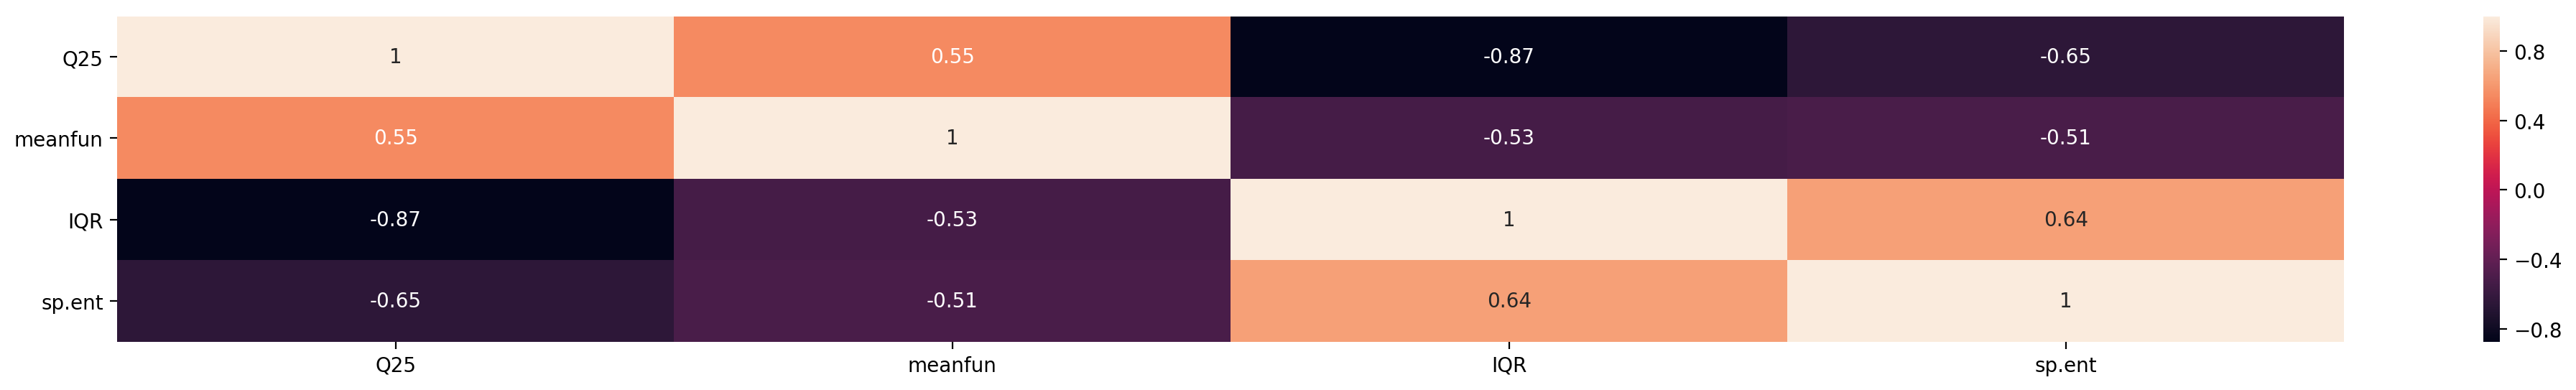

In [274]:
kolrelacjeOcen=dane.corr().loc[['Q25','meanfun','IQR','sp.ent'],['Q25','meanfun','IQR','sp.ent']]
plt.figure(figsize=(25, 3), dpi = 200)
sns.heatmap(kolrelacjeOcen, annot = kolrelacjeOcen)

Do dalszej analizy zostały wzięte atrybuty z powyższej mapy o najmniejszej korelacji wzajemnej, tj. meanfun oraz Q25.

## Przygotowanie danych do analizy 


In [275]:
dane= pd.read_csv('voice.csv')
dane=dane.replace(0, dane.mean())

W celu przygotowania danych do analizy brakujące dane zostały zastąpione średnią wartością atrybutu. 

## Grupowanie
Analiza podobieństwa między danymi przy pomocy algorytmów grupowania wraz z analizą ilości grup.

###  Hierarchiczne grupowanie aglomeracyjne
Grupowanie na podstawie wszystkich argumentów:

NameError: name 'dif' is not defined

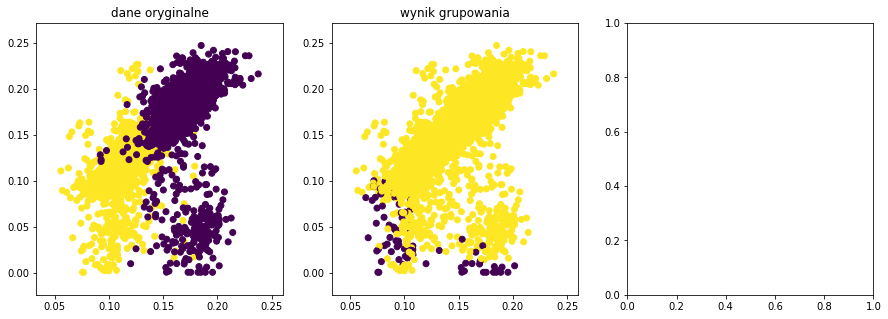

In [276]:
ile_grup = 2
df_org = pd.read_csv('voice.csv')
df = df_org.drop(columns = ['label'])

model = AgglomerativeClustering(linkage='complete', n_clusters=ile_grup)
model.fit(df)

klasa = df_org['label'].astype('category').cat.codes
grupa = model.labels_

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.scatter( x=df_org['meanfun'], y=df_org['Q25'], c=klasa)
plt.title('dane oryginalne')
plt.subplot(1,3,2)
df['grupa']=  model.labels_
plt.scatter( x=df['meanfun'], y=df['Q25'], c=grupa)
plt.title('wynik grupowania')
plt.subplot(1,3,3)
pomylki = pd.crosstab(df_org['label'],dif['grupa'])
print(pomylki)
sns.heatmap(pomylki,annot = pomylki)
plt.title('macierz pomyłek')

Grupowanie na podstawie argumentów meanfun oraz Q25, które są najmocniej skorelowane z płcią.

In [ ]:
ile_grup = 2
df_org = pd.read_csv('voice.csv')
df = df_org.loc[:,['meanfun','Q25']]

model = AgglomerativeClustering(linkage='complete', n_clusters=ile_grup)
model.fit(df)

klasa = df_org['label'].astype('category').cat.codes
grupa = model.labels_

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.scatter( x=df_org['meanfun'], y=df_org['Q25'], c=klasa)
plt.title('dane oryginalne')
plt.subplot(1,3,2)
df['grupa']=  model.labels_
plt.scatter( x=df['meanfun'], y=df['Q25'], c=grupa)
plt.title('wynik grupowania')
plt.subplot(1,3,3)
pomylki = pd.crosstab(df_org['label'],df['grupa'])
print(pomylki)
sns.heatmap(pomylki,annot = pomylki)
plt.title('macierz pomyłek')

### Metoda k-średnich
Grupowanie na podstawie argumentów meanfun oraz Q25, które są najmocniej skorelowane z płcią.

In [ ]:
k = 2
df_org = pd.read_csv('voice.csv')
df = df_org.loc[:,['meanfun','Q25']]

kmeans = KMeans(n_clusters=k, random_state=0)
kmeans.fit(df)
df['grupa']=  kmeans.labels_
etykiety_klastrow = kmeans.fit_predict(df)


plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.scatter( x=df_org['meanfun'], y=df_org['Q25'], c=klasa)
plt.title('dane oryginalne')

plt.subplot(1,3,2)

plt.scatter( x=df['meanfun'], y=df['Q25'], c=grupa)
plt.title('wynik grupowania')
plt.subplot(1,3,3)

pomylki = pd.crosstab(df_org['label'],df['grupa'])
print(pomylki)
sns.heatmap(pomylki,annot = pomylki)
plt.title('macierz pomyłek')

Jak widać dla danego zbioru danych, grupowanie nie daje większych rezultatów, z"właszcza przy grupowaniu na podstawie wszystkich atrybutów. Nieco lepszy efekt grupowania został osiągnięty dla grupowania na podstawie dwóch argumentów, mocno skorelowanych z atrubytem określającym płeć posiadaczy głosu, którego parametry były analizowane. Metoda aglomeracyjna oraz k-średnich dawały bardzo podobne wyniki grupowania.

# Klasyfikacja

## Metoda najbliższego sąsiada

In [ ]:
def podziel(df,proporcja):
    opis_ucz, opis_test, dec_ucz, dec_test = train_test_split(df.iloc[:,0:-1], df.iloc[:,-1].astype('category').cat.codes, test_size=proporcja)
    return {"opis_ucz":opis_ucz, "opis_test":opis_test, "dec_ucz":dec_ucz, "dec_test":dec_test}

In [ ]:
def weryfikuj(model,dane,atryb):
    model.fit(dane["opis_ucz"].iloc[:,atryb], dane["dec_ucz"])
    wynik_ucz = model.predict(dane["opis_ucz"].iloc[:,atryb])
    wynik_test = model.predict(dane["opis_test"].iloc[:,atryb])
    print("Macierz pomyłek dla zbioru uczącego")
    print(pd.crosstab(dane["dec_ucz"],wynik_ucz)) 
    print("Macierz pomyłek dla zbioru testowego")
    print(pd.crosstab(dane["dec_test"],wynik_test)) 

In [ ]:
def granice(model,dane,atr_x, atr_y,tytul,kontur = 1):
    if (kontur == 1):    
        model.fit(dane["opis_ucz"].iloc[:,[atr_x,atr_y]], dane["dec_ucz"])
        x_min = min(dane["opis_ucz"].iloc[:, atr_x].min(),dane["opis_test"].iloc[:, atr_x].min())
        x_max = max(dane["opis_ucz"].iloc[:, atr_x].max(),dane["opis_test"].iloc[:, atr_x].max())
        y_min = min(dane["opis_ucz"].iloc[:, atr_y].min(),dane["opis_test"].iloc[:, atr_y].min())
        y_max = max(dane["opis_ucz"].iloc[:, atr_y].max(),dane["opis_test"].iloc[:, atr_y].max())
        rozst_x = x_max - x_min
        rozst_y = y_max - y_min
        x_min = x_min - 0.1*rozst_x
        x_max = x_max + 0.1*rozst_x
        y_min = y_min - 0.1*rozst_y
        y_max = y_max + 0.1*rozst_y       
        xx, yy = np.meshgrid(np.arange(x_min, x_max, (x_max-x_min)/150),
                     np.arange(y_min, y_max, (y_max-y_min)/150))
        Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
    plt.figure(dpi = 100)
    plt.title(tytul)
    if (kontur == 1):
        plt.contourf(xx, yy, Z, levels = 4, alpha=0.2)
    plt.scatter(dane["opis_ucz"].iloc[:, atr_x], dane["opis_ucz"].iloc[:, atr_y], c=dane["dec_ucz"], marker = '.')
    plt.scatter(dane["opis_test"].iloc[:, atr_x], dane["opis_test"].iloc[:, atr_y], c=dane["dec_test"], marker = 'x')

In [ ]:
nazwa_pliku = 'voice.csv'
df = pd.read_csv(nazwa_pliku)
d= podziel(df,0.3)
model = KNeighborsClassifier(n_neighbors=1)
ax, ay = 3,12
granice(model,d,ax,ay,"klasyfikator 1-NN dla zbioru " + nazwa_pliku)
weryfikuj(model,d,[ax,ay])

Powyższa klasyfikacja została przeprowadzona metodą 1-Najbliższych sąsiadów dla argumentów Q25 oraz meanfun. Jak widać klasyfikowanie odbyło się w sposób dość poprawny - około 900 wyników zostało poprawnie przyporządkowanych przy około 30 - 40 wynikach źle rozpoznanych.

In [ ]:
nazwa_pliku = 'voice.csv'
df = pd.read_csv(nazwa_pliku)
d= podziel(df,0.3)
model = KNeighborsClassifier(n_neighbors=1)
ax, ay = 5,12
granice(model,d,ax,ay,"klasyfikator 1-NN dla zbioru " + nazwa_pliku)
weryfikuj(model,d,[ax,ay])

Powyższa klasyfikacja została przeprowadzona metodą 1-Najbliższych sąsiadów dla argumentów IQR oraz meanfun. Wyniki klasyfikacji są bardzo zbliżone do wyników klasyfikacji - około 900 wyników zostało poprawnie przyporządkowanych przy około 30 - 40 wynikach źle rozpoznanych.

In [ ]:
nazwa_pliku = 'voice.csv'
df = pd.read_csv(nazwa_pliku)
d= podziel(df,0.3)
model = KNeighborsClassifier(n_neighbors=1)
ax, ay = 13,14
granice(model,d,ax,ay,"klasyfikator 1-NN dla zbioru " + nazwa_pliku)
weryfikuj(model,d,[ax,ay])

Powyższa klasyfikacja została przeprowadzona metodą 1-Najbliższych sąsiadów dla argumentów minifun oraz maxfun, które w odróżnieniu od wyżej użytych atrybutów nie są skorelowane z atrybutem określającym płeć. Wyniki klasyfikacji są niezbyt poprawne - skuteczność wynosioła około 50 %. Udowadnia to, że istotne jest wybieranie atrybutów mocno skorelowanych z atrybutem decydującym o klasyfikacji.

## Naiwny klasyfikator Bayesa

In [ ]:
nazwa_pliku = 'voice.csv'
df = pd.read_csv(nazwa_pliku)
df=df.replace(0, df.mean())
d = podziel(df,0.3)
model = GaussianNB()
granice(model,d,3,12,"klasyfikator Bayesa dla zbioru " + nazwa_pliku)
weryfikuj(model,d,[3,12])

Powyższa klasyfikacja została przeprowadzona metodą naiwnej klasyfikacji Bayesa dla argumentów Q25 oraz meanfun. Wyniki klasyfikacji są bardzo zbliżone do wyników klasyfikacji - około 900 wyników zostało poprawnie przyporządkowanych przy około 30 - 40 wynikach źle rozpoznanych.

In [ ]:
nazwa_pliku = 'voice.csv'
df = pd.read_csv(nazwa_pliku)
df=df.replace(0, df.mean())
d = podziel(df,0.3)
model = GaussianNB()
granice(model,d,15,16,"klasyfikator Bayesa dla zbioru " + nazwa_pliku)
weryfikuj(model,d,[15,16])

Powyższa klasyfikacja została przeprowadzona metodą naiwnej klasyfikacji Bayesa dla argumentów meandom oraz mindom, które w odróżnieniu od wyżej użytych atrybutów nie są skorelowane z atrybutem określającym płeć. Wyniki klasyfikacji są niepoprawne - skuteczność wynosioła poniżej 50 %. Widać też, że naiwny klasyfikator Bayesa gorzej klasyfikuje w przypadku danych nieskorelowanych

## Drzewa decyzyjne 

In [ ]:
nazwa_pliku = 'voice.csv'
# wczytanie badanego zbioru danych
df = pd.read_csv(nazwa_pliku)
# podział zbioru danych
d = podziel(df,0.3)
model = tree.DecisionTreeClassifier(max_depth=4)
# granice dycyzyjne
granice(model,d,3,12,"drzewo decyzyjne dla zbioru " + nazwa_pliku)
# weryfikacja
weryfikuj(model,d,[3,12])

In [ ]:
nazwa_pliku = 'voice.csv'
# wczytanie badanego zbioru danych
df = pd.read_csv(nazwa_pliku)
# podział zbioru danych
d = podziel(df,0.3)
# zdefiniowanie modelu klasyfikatora
model = tree.DecisionTreeClassifier(max_depth=4)
# granice dycyzyjne
granice(model,d,3,5,"drzewo decyzyjne dla zbioru " + nazwa_pliku)
# weryfikacja
weryfikuj(model,d,[3,5])

Jak widać klasyfikator zbudowany za pomocą drzewa decyzyjnego osiąga bardzo zbliżone rezulataty do poprzednich klasyfikatorów przy użyciu jednkowych danych(Q25, meanfun). 
W drugim przypadku użyliśmy do klasyfikacji metodą drzewa decyzyjnego atrybutów Q25 i IQR, które są dość dobrze skorelowane z atrybutem określającym płeć, ale także ze sobą. Jak widać powoduje to, że wyniki klasyfikacji nieco się pogarszają i poprawnie klasyfikowanych danych ze zbioru testowego jest około 850, przy złej klasyfikacji około 80 wyników.

# Wnioski płynące z wyboru danych do klasyfikacji

Z posiadanych przez nas danych, możemy po przeprowadzonej analizie korelacji i klasyfikatorów stwierdzić, że na podstawie dostarczonych danych możemy zbudować poprawnie działający klasyfikator. Nie powinniśmy jednak w tym celu używać wszystkich atrybutów a jedynie te, które są mocno skorelowane z atrybutem określającym płeć posiadacza danej próbki głosu. Znacznie ma też czy wybrane atrybuty są mocno skorelowane między sobą, jednak nie ma to takiego wpływu jak korelacji z atrybutem płci. Ze względu na niezbyt duża korelację większości atrybutów z płcią, możemy odrzucić większość podanych atrybutów, pozostawiając do badanie jedynie to mocno skorelowane z płcią